# Elektri hinna ennustamine kasutades teeki `skforecast`

[`skforecast`](https://joaquinamatrodrigo.github.io/skforecast/0.5.1/index.html)
on `sklearn`'iga ühilduv lisa teek, aegridade ennustamieks.

**Teegid**

In [33]:
!pip install skforecast

     |████████████████████████████████| 169 kB 740 kB/s eta 0:00:01
     |████████████████████████████████| 11.7 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 31.0 MB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 9.9 MB 737 kB/s eta 0:00:01
     |████████████████████████████████| 11.3 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 308 kB 865 kB/s eta 0:00:01
     |████████████████████████████████| 283 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 17.1 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 100 kB 1.8 MB/s ta 0:00:01
     |████████████████████████████████| 80 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 209 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 1.6 MB/s eta 0:00:01
  Using cached setuptools_scm-7.0.5-py3-none-any.whl (42 kB)
  Using cached tomli-2.0.1-py3-none-any.whl (12 kB)
     |████████████████████████████████| 544 kB 3.4 MB/s eta 0:00:01
 

In [1]:
pwd

'/home/eeriksp/Develop/electricity-consumption'

In [1]:
# arvutamine ja joonistamine
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# treenimine, tulemused
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# regressorid
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# aegridade spetsiifiline
from skforecast.ForecasterAutoreg import ForecasterAutoreg


**Andmed ja puhastamine**

In [7]:
# laen treening- ja testandmed
data_raw =  pd.read_csv('./data/df_clean.csv')
test_raw = pd.read_csv('./data/df_clean_test.csv')

In [8]:
data_raw.head()

,Unnamed: 0,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,...,datetime,year,month,day,weekday,hour,date,is_holiday,season,google_trends_electricity
0,0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,0.0,0.0,320.0,7.2,16.7,...,2021-09-01 00:00:00,2021,9,1,2,0,2021-09-01,False,Autumn,5
1,1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,0.0,0.0,320.0,7.2,13.0,...,2021-09-01 01:00:00,2021,9,1,2,1,2021-09-01,False,Autumn,5
2,2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,0.0,0.0,320.0,7.2,13.0,...,2021-09-01 02:00:00,2021,9,1,2,2,2021-09-01,False,Autumn,5
3,3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,0.0,0.0,330.0,7.2,13.0,...,2021-09-01 03:00:00,2021,9,1,2,3,2021-09-01,False,Autumn,5
4,4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,0.0,0.0,300.0,3.6,13.0,...,2021-09-01 04:00:00,2021,9,1,2,4,2021-09-01,False,Autumn,5


In [28]:
data = data_raw.set_index(pd.to_datetime(data_raw['timestamp']))[["consumption"]]
data = data[~data.index.duplicated()].asfreq("H").sort_index()

test = test_raw.set_index(pd.to_datetime(test_raw['timestamp']))[[]]
test = test[~test.index.duplicated()].asfreq("H").sort_index()
test = test.tz_localize("+03:00")

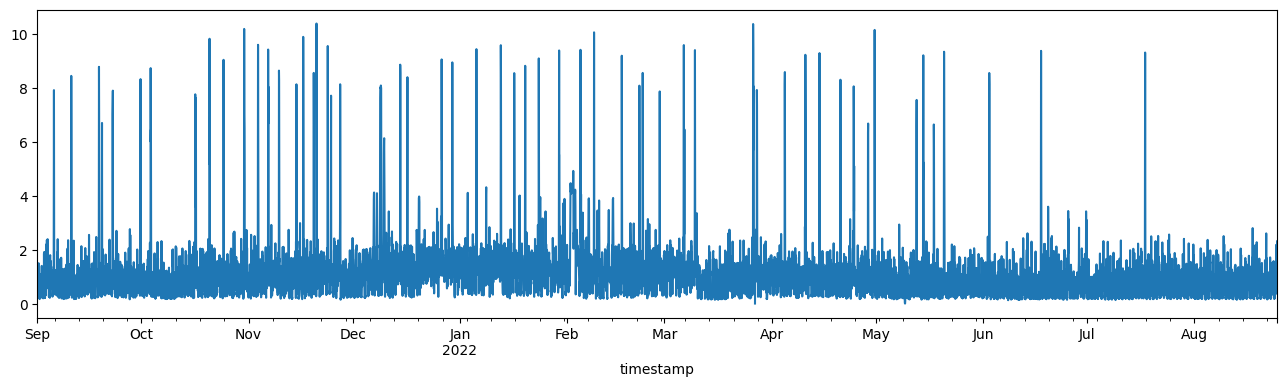

In [17]:
fig, ax=plt.subplots(figsize=(16, 4))
data["consumption"].plot()
plt.show()

In [18]:
data.shape
train = data[7900:8000]
val = data[8000:8050]

val.head()

,consumption
timestamp,
2022-07-31 08:00:00,0.942
2022-07-31 09:00:00,0.714
2022-07-31 10:00:00,0.294
2022-07-31 11:00:00,0.672
2022-07-31 12:00:00,0.812


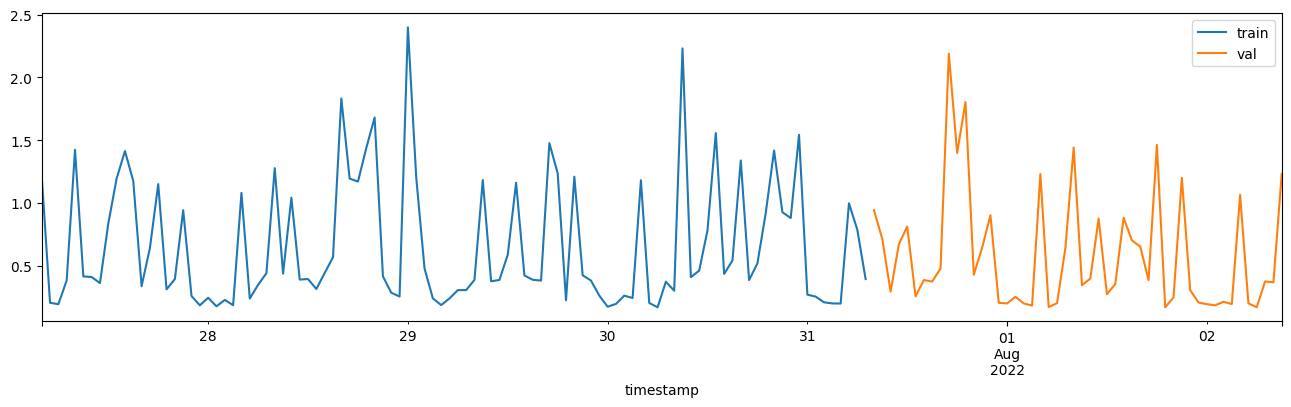

In [19]:
fig, ax=plt.subplots(figsize=(16, 4))
train["consumption"].plot(ax=ax, label="train")
val["consumption"].plot(ax=ax, label="val")
plt.legend()
plt.show()

In [20]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(n_estimators=1000),
                lags      = 20
             )

forecaster.fit(y=train["consumption"])

In [21]:
predictions = forecaster.predict(50)

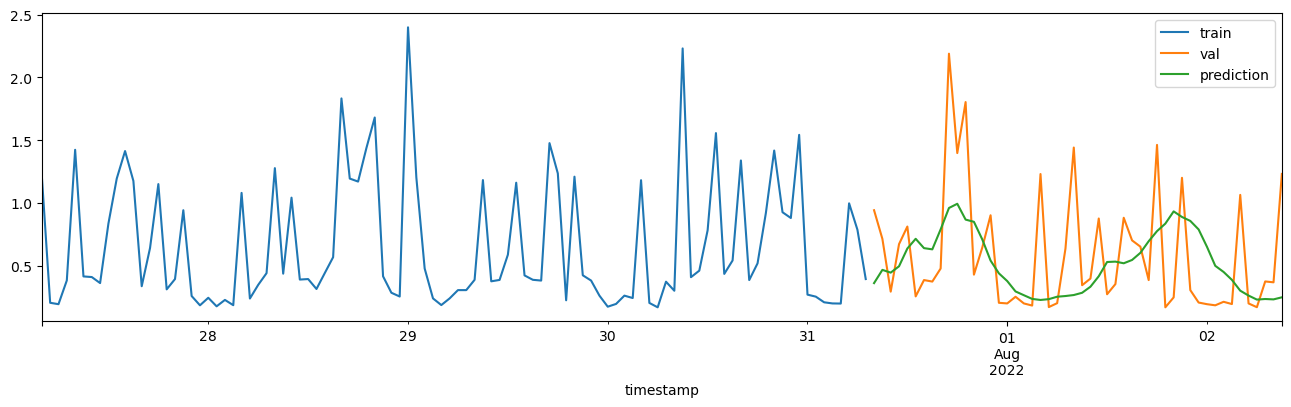

In [87]:
fig, ax=plt.subplots(figsize=(16, 4))
train["consumption"].plot(ax=ax, label="train")
val["consumption"].plot(ax=ax, label="val")
predictions.plot(ax=ax, label="prediction")
plt.legend()
plt.show()

In [25]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(n_estimators=1000),
                lags      = 20
             )

forecaster.fit(y=data["consumption"].fillna(method="ffill"))

In [29]:
submission_1 = pd.DataFrame(
    {'time': test.index, 'consumption': forecaster.predict(len(test))},
    columns = ['time', 'consumption'])
submission_1.to_csv('submission_skforecast.csv', index=False)